# Explore Dataset
Explore vehicle detection dataset.

## Imports

In [2]:
import cv2
import numpy as np
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip

# Local
import utilities as utils

%matplotlib inline

## Load Data

In [3]:
cars     = glob.glob('training_images/vehicles/*/*.png')
non_cars = glob.glob('training_images/non-vehicles/*/*.png')

data_info = utils.data_look(cars, non_cars)

print('This dataset has ', data_info['n_cars'], ' images of cars and ', data_info['n_notcars'], ' images of non cars.')
print('The images are of size', data_info['image_shape'] , ' and type ', data_info['data_type'], '.')

This dataset has  8792  images of cars and  8968  images of non cars.
The images are of size (64, 64, 3)  and type  float32 .


## Visualize Data

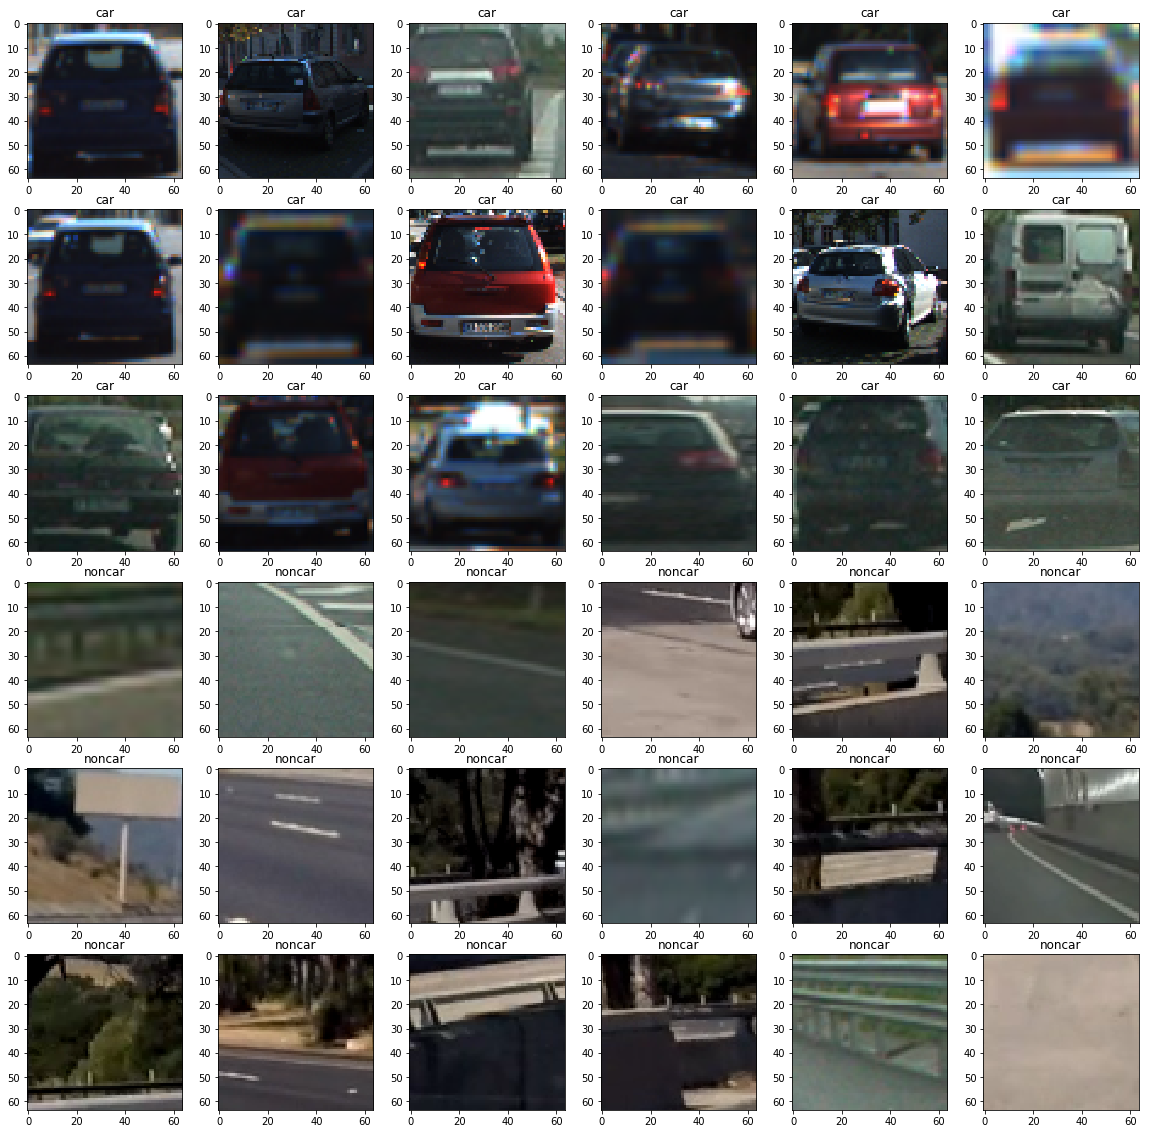

In [4]:
fig, axs = plt.subplots(6,6, figsize=(20, 20))
axs = axs.ravel()

for n in range(18):
    # Generate a random int
    cars_idx = np.random.randint(0, len(cars))
    
    # Read the image, and convert to RGB
    car_img = cv2.imread(cars[cars_idx])
    car_img = cv2.cvtColor(car_img, cv2.COLOR_BGR2RGB)
    
    axs[n].imshow(car_img)
    axs[n].set_title('car')
    
for n in range(18,36):
    # Generate a random int
    non_cars_idx = np.random.randint(0, len(non_cars))
    
    # Read the image, and convert to RGB
    noncar_img = cv2.imread(non_cars[non_cars_idx])
    noncar_img = cv2.cvtColor(noncar_img, cv2.COLOR_BGR2RGB)
    
    axs[n].imshow(noncar_img)
    axs[n].set_title('noncar')

## Extract HOG Features

Text(0.5,1,'HOG Visualization')

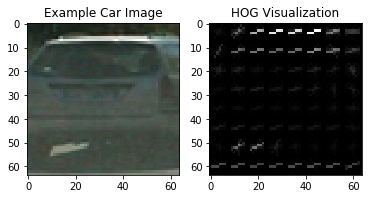

In [5]:
pix_per_cell = 8
cell_per_block = 2
orient = 9

# Convert a car image to gray scale
gray = cv2.cvtColor(car_img, cv2.COLOR_RGB2GRAY)

# Detect and extract HOG Features
features, hog_image = utils.hog(gray, orientations=orient,
                          pixels_per_cell=(pix_per_cell, pix_per_cell), 
                          cells_per_block=(cell_per_block, cell_per_block), 
                          visualise=True, feature_vector=False,
                          block_norm="L2-Hys")

# Visualize features
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_img, cmap='gray')
plt.title('Example Car Image')

plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

## Prepare dataset

In [6]:
# Extract features from all images
car_features    = utils.extract_features(cars, cspace='YUV',hog_channel='ALL')
noncar_features = utils.extract_features(non_cars, cspace='YUV',hog_channel='ALL')

# Assemble dataset
X = np.vstack((car_features, noncar_features)).astype(np.float64)
y = np.hstack((np.ones(len(car_features)), np.zeros(len(noncar_features))))

In [7]:
# Split dataset into training and test set
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)


## Train classifier

In [8]:
from sklearn.model_selection import GridSearchCV

svc = LinearSVC()

# Try grid search
#svc = SVC()
#params = {'kernel': ('linear','rbf'), 'C': [1, 5, 10]}
#clf = GridSearchCV(svc, params)

#clf.fit(X_train, y_train)
#print(clf.best_params_)

svc.fit(X_train, y_train)

test_accuracy = svc.score(X_test, y_test)
print('Test Accuracy: ', test_accuracy)

Test Accuracy:  0.982545045045


## Evaluate classifier on test images

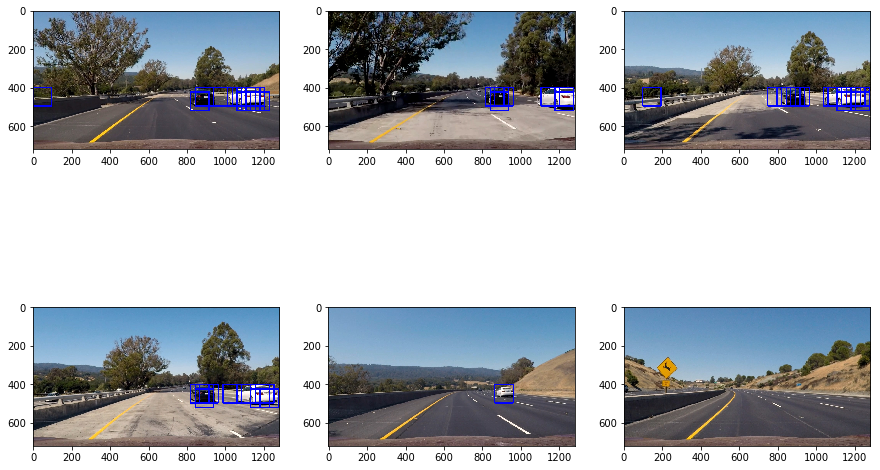

In [9]:
# Set up parameters
ystart = 400
ystop = 656
scale = 1.5
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

fig, axs = plt.subplots(2,3, figsize=(15, 10))
axs = axs.ravel()

# Get test image names
test_img_names = glob.glob('test_images/*.jpg')
for axs_id, img_name in enumerate(test_img_names):
    # Read the image
    test_img = mpimg.imread(img_name)
    
    # Find detections
    rectangles = utils.find_cars(test_img, colorspace, ystart, ystop, scale, svc, hog_channel, orient, pix_per_cell, cell_per_block)
    
    # Draw detections on image
    test_img_viz = utils.draw_boxes(test_img, rectangles)
    
    axs[axs_id].imshow(test_img_viz)

#test_img = mpimg.imread('test_images/test1.jpg')
#rectangles = utils.find_cars(test_img, colorspace, ystart, ystop, scale, svc, hog_channel, orient, pix_per_cell, cell_per_block)
#test_img_viz = utils.draw_boxes(test_img, rectangles)
#plt.imshow(test_img_viz)

## Tune parameters for scale-aware sliding window search

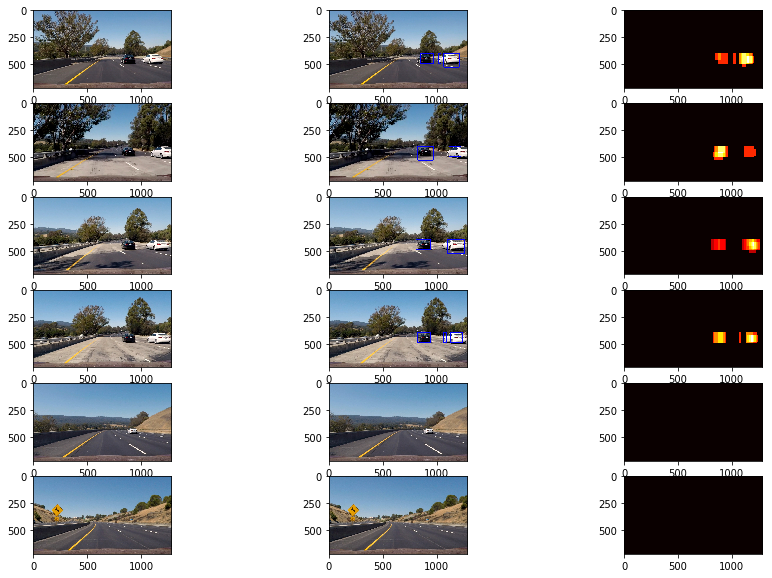

In [15]:
def detect_cars(img):
    rectangles = []
    
    colorspace     = 'YUV'
    orient         = 9
    pix_per_cell   = 8
    cell_per_block = 2
    hog_channel    = 'ALL'
    
    # Cars that are further away
    ystart = 400
    ystop  = 464
    scale  = 1.0
    far_cars = utils.find_cars(img, colorspace, ystart, ystop, scale, svc, hog_channel, orient, pix_per_cell, cell_per_block)
    rectangles.append(far_cars)
    
    ystart = 424
    ystop  = 488
    scale  = 1.0
    more_far_cars = utils.find_cars(img, colorspace, ystart, ystop, scale, svc, hog_channel, orient, pix_per_cell, cell_per_block)
    rectangles.append(more_far_cars)
    
    # Cars that are midway
    ystart = 400
    ystop  = 496
    scale  = 1.5
    mid_cars = utils.find_cars(img, colorspace, ystart, ystop, scale, svc, hog_channel, orient, pix_per_cell, cell_per_block)
    rectangles.append(mid_cars)
    
    ystart = 448
    ystop  = 544
    scale  = 1.5
    more_mid_cars = utils.find_cars(img, colorspace, ystart, ystop, scale, svc, hog_channel, orient, pix_per_cell, cell_per_block)
    rectangles.append(more_mid_cars)
    
    ystart = 496
    ystop  = 592
    scale  = 1.5
    even_more_mid_cars = utils.find_cars(img, colorspace, ystart, ystop, scale, svc, hog_channel, orient, pix_per_cell, cell_per_block)
    rectangles.append(even_more_mid_cars)
    
    # Cars that are close by
    ystart = 400
    ystop  = 528
    scale  = 2.0
    near_cars = utils.find_cars(img, colorspace, ystart, ystop, scale, svc, hog_channel, orient, pix_per_cell, cell_per_block)
    rectangles.append(near_cars)
    
    ystart = 448
    ystop  = 576
    scale  = 2.0
    more_near_cars = utils.find_cars(img, colorspace, ystart, ystop, scale, svc, hog_channel, orient, pix_per_cell, cell_per_block)
    rectangles.append(more_near_cars)
    
    ystart = 416
    ystop  = 416+192
    scale  = 3.0
    even_more_near_cars = utils.find_cars(img, colorspace, ystart, ystop, scale, svc, hog_channel, orient, pix_per_cell, cell_per_block)
    rectangles.append(even_more_near_cars)
    
    rectangles = [item for sublist in rectangles for item in sublist]
    
    return rectangles

def detect_cars_and_draw(img):
    rectangles = detect_cars(img)
    
    # Make a heat map of detections
    heat_img = np.zeros_like(img[:,:,0])
    heat_img = utils.add_heat(heat_img, rectangles)
    heat_img = utils.apply_threshold(heat_img, 2)
    
    # Compute labels
    labels = label(heat_img)
    
    # Draw labels
    viz_img = utils.draw_labeled_bboxes(np.copy(img), labels)
    
    return viz_img

fig, axs = plt.subplots(6,3, figsize=(15, 10))
axs = axs.ravel()

for axs_id, img_name in enumerate(test_img_names):
    # Read the image
    test_img = mpimg.imread(img_name)
    
    # Detect cars
    rectangles = detect_cars(test_img)
    
    # Make heat map
    heat_img = np.zeros_like(test_img[:,:,0])
    heat_img = utils.add_heat(heat_img, rectangles)
    heat_img = utils.apply_threshold(heat_img, 2)
    
    # Compute labels
    labels = label(heat_img)
    
    # Draw labels
    viz_img = utils.draw_labeled_bboxes(np.copy(test_img), labels)
    
    # Draw image
    axs[axs_id*3].imshow(test_img)
    axs[axs_id*3+1].imshow(viz_img)
    axs[axs_id*3+2].imshow(heat_img,cmap='hot')

## Detection pipeline results

In [ ]:
out_file = 'test_video_detection_only.mp4'
clip = VideoFileClip('test_video.mp4')

clip_out = clip.fl_image(detect_cars_and_draw)
clip_out.write_videofile(out_file, audio=False)

In [19]:
class DetectionContainer():
    def __init__(self):
        self.history_len = 15
        self.old_detections = []
    
    def add_rects(self, rects):
        self.old_detections.append(rects)
        if len(self.old_detections) > self.history_len:
            self.old_detections = self.old_detections[len(self.old_detections)-self.history_len:]
    

def detect_and_track_cars(img):
    
    rectangles = detect_cars(img)
    
    if len(rectangles)>0:
        det_cont.add_rects(rectangles)
    
    heat_img = np.zeros_like(img[:,:,0])
    for detections in det_cont.old_detections:
        heat_img = utils.add_heat(heat_img, detections)
        
    thresh = 20

    heat_img = utils.apply_threshold(heat_img, thresh)
        
    labels = label(heat_img)
        
    viz_img = utils.draw_labeled_bboxes(np.copy(img), labels)
    return viz_img


#det_cont = DetectionContainer()

#out_file = 'test_video_detection_and_tracking.mp4'
#clip = VideoFileClip('test_video.mp4')

#clip_out = clip.fl_image(detect_and_track_cars)
#clip_out.write_videofile(out_file, audio=False)

det_cont = DetectionContainer()
out_file = 'project_video_detection_and_tracking.mp4'
clip = VideoFileClip('project_video.mp4')

clip_out = clip.fl_image(detect_and_track_cars)
clip_out.write_videofile(out_file, audio=False)

[MoviePy] >>>> Building video project_video_detection_and_tracking.mp4
[MoviePy] Writing video project_video_detection_and_tracking.mp4



 12%|█▏        | 152/1261 [01:07<08:10,  2.26it/s]


 24%|██▍       | 303/1261 [02:13<06:43,  2.37it/s]


 36%|███▌      | 454/1261 [03:20<06:01,  2.23it/s]


 48%|████▊     | 605/1261 [04:28<04:41,  2.33it/s]


 60%|█████▉    | 756/1261 [05:34<03:46,  2.23it/s]


 72%|███████▏  | 907/1261 [06:40<02:35,  2.28it/s]


 84%|████████▍ | 1057/1261 [07:46<01:29,  2.29it/s]


 96%|█████████▌| 1205/1261 [08:51<00:23,  2.38it/s]


100%|█████████▉| 1260/1261 [09:16<00:00,  2.12it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_detection_and_tracking.mp4 



In [ ]:
out_file = 'project_video_detection_only.mp4'
clip = VideoFileClip('project_video.mp4')
clip_out = clip.fl_image(detect_cars_and_draw)
clip_out.write_videofile(out_file, audio=False)

## Code to Demonstrate Sliding Window Search

In [ ]:
def show_sliding_window_search(img):
    rectangles = []
    
    colorspace     = 'YUV'
    orient         = 9
    pix_per_cell   = 8
    cell_per_block = 2
    hog_channel    = 0
    
    # Cars that are further away
    ystart = 400
    ystop  = 464
    scale  = 1.0
    far_cars = utils.find_cars(img, colorspace, ystart, ystop, scale, svc, hog_channel, orient, pix_per_cell, cell_per_block, show_window_search=True)
    rectangles.append(far_cars)
    
    ystart = 424
    ystop  = 488
    scale  = 1.0
    more_far_cars = utils.find_cars(img, colorspace, ystart, ystop, scale, svc, hog_channel, orient, pix_per_cell, cell_per_block, show_window_search=True)
    rectangles.append(more_far_cars)
    
    # Cars that are midway
    ystart = 400
    ystop  = 496
    scale  = 1.5
    mid_cars = utils.find_cars(img, colorspace, ystart, ystop, scale, svc, hog_channel, orient, pix_per_cell, cell_per_block, show_window_search=True)
    rectangles.append(mid_cars)
    
    ystart = 448
    ystop  = 544
    scale  = 1.5
    more_mid_cars = utils.find_cars(img, colorspace, ystart, ystop, scale, svc, hog_channel, orient, pix_per_cell, cell_per_block, show_window_search=True)
    rectangles.append(more_mid_cars)
    
    ystart = 496
    ystop  = 592
    scale  = 1.5
    even_more_mid_cars = utils.find_cars(img, colorspace, ystart, ystop, scale, svc, hog_channel, orient, pix_per_cell, cell_per_block, show_window_search=True)
    rectangles.append(even_more_mid_cars)
    
    # Cars that are close by
    ystart = 400
    ystop  = 528
    scale  = 2.0
    near_cars = utils.find_cars(img, colorspace, ystart, ystop, scale, svc, hog_channel, orient, pix_per_cell, cell_per_block, show_window_search=True)
    rectangles.append(near_cars)
    
    ystart = 448
    ystop  = 576
    scale  = 2.0
    more_near_cars = utils.find_cars(img, colorspace, ystart, ystop, scale, svc, hog_channel, orient, pix_per_cell, cell_per_block, show_window_search=True)
    rectangles.append(more_near_cars)
    
    ystart = 416
    ystop  = 416+192
    scale  = 3.0
    even_more_near_cars = utils.find_cars(img, colorspace, ystart, ystop, scale, svc, hog_channel, orient, pix_per_cell, cell_per_block, show_window_search=True)
    rectangles.append(even_more_near_cars)
    
    rectangles = [item for sublist in rectangles for item in sublist]
    
    viz_img = utils.draw_boxes(np.copy(img), rectangles)
    
    return viz_img

viz_img = show_sliding_window_search(test_img)
plt.imshow(viz_img)